### Laboratorium 4 - zadania

Dany jest zbiór obrazów wraz z etykietami - maskami segmentacji. Twoim zadaniem jest zaproponować metodę binaryzacji obrazów, zaimplementować odpowiednie metryki oceny i wykorzystać je do określenia jakości detekcji w zależności od parametrów metody.

Pytania zadane kursywą możesz traktować jako "zajawki" do sprawozdania.

Dołączony w zadaniu dataset jest podzbiorem datasetu dostępnego w oryginale na portalu [Kaggle](https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy).

In [1]:
import os
from typing import Iterator, List, Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt

Do podanego zbioru danych zaimplementowany został poniższy loader. Możesz korzystać z niego albo przez interfejs listy (`loader[3]`) albo przez interfejs iteracyjny (`for sample in loader`). W obu przypadkach zwracana jest para (obraz, etykieta), gdzie obraz jest 3-kanałowym obrazem **RGB** a etykieta 1-kanałowym obrazem o wartościach 0 (tło) i 1 (obiekt-bakteria). Poniższa komórka zawiera przykład.

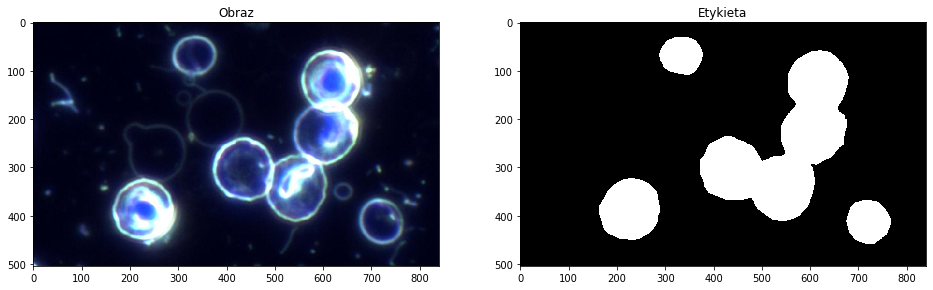

In [2]:
class BacteriaLoader:
    SUBSET = 89, 155
    def __init__(self, root:str, train:bool=True) -> None:
        """
        root (str): path to the folder containing 'images', 'masks' and 'meta.json'
        train (bool): if True, returns the calibration subset, otherwise the validation subset
        """
        image_names = os.listdir(os.path.join(root, 'images'))
        mask_names = os.listdir(os.path.join(root, 'masks'))
        valid_names = self.get_names()
        if any(name not in image_names or name not in mask_names for name in valid_names):
            raise FileNotFoundError("Dataset malformed: files missing.")
        image_names = [os.path.join(root, 'images', file_name) for file_name in valid_names]
        mask_names = [os.path.join(root, 'masks', file_name) for file_name in valid_names]
        test_image_names = image_names[::3]
        train_image_names = [name for name in image_names if name not in test_image_names]
        self.image_names = train_image_names if train else test_image_names
        test_mask_names = mask_names[::3]
        train_mask_names = [name for name in mask_names if name not in test_mask_names]
        self.mask_names = train_mask_names if train else test_mask_names

    def get_names(self) -> List[str]:
        return ['{:03d}.png'.format(i) for i in range(*self.SUBSET)]

    def __getitem__(self, index:int) -> Tuple[np.ndarray, np.ndarray]:
        image = cv2.imread(self.image_names[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_ = cv2.imread(self.mask_names[index], cv2.IMREAD_GRAYSCALE)
        mask = np.zeros_like(mask_, dtype=np.uint8)
        mask[mask_==1] = 1  # pozostałe obiekty ignorujemy
        return image, mask

    def __len__(self) -> int:
        return len(self.image_names)

    def __iter__(self) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        for i in range(len(self)):
            yield self[i]


loader = BacteriaLoader('BacteriaKaggle')
image, mask = loader[21]
f, (axi, axm) = plt.subplots(1, 2)
f.set_figwidth(16)
f.set_figheight(8)
axi.imshow(image, interpolation='none');
axi.set_title('Obraz');
axm.imshow(mask*100, interpolation='none', cmap='gray');
axm.set_title('Etykieta');

#### Zadanie 1 (1.0 pkt | 0.5 pkt)

Zaimplementuj w funkcji `detect_bacteria` taki algorytm przetwarzania obrazu, by uzyskać wizualnie akceptowalną binaryzację. Użyj operacji morfologicznych do odfiltrowania artefaktów. Nie staraj się na tym etapie dążyć do idealnych rezultatów - dokładny dobór parametrów algorytmu będzie jednym z następnych kroków.

Do testowania użyj poniższej komórki. Zwróć uwagę na interfejs `**params` - przekazywanie parametrów metody (np. wartości progów, rozmiary kerneli) tą drogą znacznie uprości pracę na dalszych etapach. W razie potrzeby, zapoznaj się z pythonowym mechanizmem [`kwargs`](https://book.pythontips.com/en/latest/args_and_kwargs.html#usage-of-kwargs).

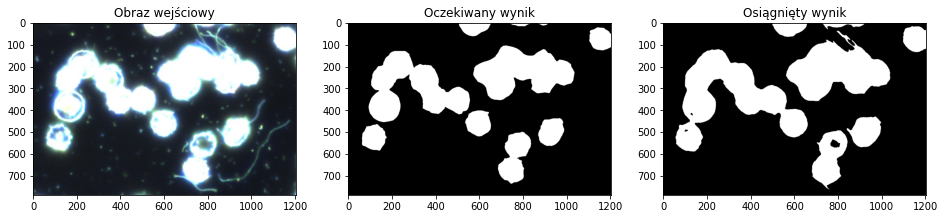

In [3]:
def detect_bacteria(image:np.ndarray, **params) -> np.ndarray:
    # wartości parametrów przekazuj w 'params', np.: params['threshold']
    kernel = np.eye(params.setdefault('kernel', 15), dtype=np.uint8)
    if params.setdefault('channel', 'mean') == 'mean':
        output = image.mean(axis=2).astype(np.uint8)
    else:
        output = image[...,params['channel']]
    # output = np.zeros_like(image[..., 0], dtype=np.uint8)
    for _ in range(params.setdefault('openings', 1)):
        output = cv2.erode(output, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
        output = cv2.dilate(output, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    if params.setdefault('threshold', 'otsu') == 'otsu':
        _, output = cv2.threshold(output, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        _, output = cv2.threshold(output, params['threshold'], 255, cv2.THRESH_BINARY)
    return output

dev_image, dev_mask = loader[0] # sprawdź też inne przykłady, np. 9, 37
output = detect_bacteria(dev_image, threshold='otsu', kernel=15, channel='mean', openings=1)

# wyświetlanie
f, (a_img, a_mask, a_pred) = plt.subplots(1, 3)
f.set_figwidth(16)
f.set_figheight(8)
a_img.imshow(dev_image)
a_img.set_title('Obraz wejściowy');
a_mask.imshow(dev_mask, cmap='gray')
a_mask.set_title('Oczekiwany wynik');
a_pred.imshow(output, cmap='gray')
a_pred.set_title('Osiągnięty wynik');

#### Zadanie 2 (1.0 pkt | 0.5 pkt)

Zaimplementuj funkcję `measure` w taki sposób, by wyliczała wybrane przez Ciebie metryki (uwzględnij co najmniej precyzję, czułość, oraz indeks Jaccarda) i zwracała je w formie słownika. Wykorzystaj ją do określenia błędu pomiędzy wynikiem działania twojej funkcji, a maską dla różnych wartości wybranych parametrów (patrz: przykład). Wykonaj testy dla kilku odróżniających się przykładów.  
_Co stanowi przyczynę błędów? Zwróć uwagę na specyfikę obrazów i zasady działania stosowanych algorytmów._

{'precision': 0.8793980729674137, 'recall': 0.5110733610167358, 'f1': 0.6464525884365923, 'iou': 0.47759877704609593}


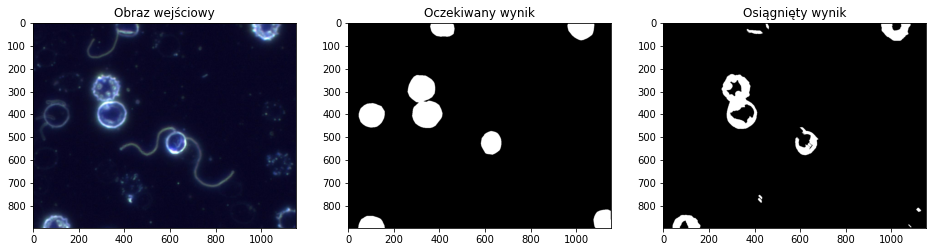

In [101]:
from sklearn import metrics
from copy import copy
from random import sample
import random

def measure(predicted, truth):
    predicted = predicted.flatten().astype(bool)
    truth = truth.flatten().astype(bool)
    scores = {}
    scores['precision'] = metrics.precision_score(truth, predicted)
    scores['recall'] = metrics.recall_score(truth, predicted)
    scores['f1'] = metrics.f1_score(truth, predicted)
    scores['iou'] = metrics.jaccard_score(truth, predicted)
    return scores

def plot_results(default_params, params, samples, metric_labels, plot_colors=['r','g','b','c']):
    fig, ax = plt.subplots(1,len(params), figsize=(10*len(params),10))
    for i in range(len(params)):
        param_values = []
        mean_values = {}
        var_values = {}
        for label in metric_labels:
            mean_values[label] = []
            var_values[label] = []
        for param_val in params[list(params.keys())[i]]:
            cur_params = copy(default_params)
            cur_params[list(params.keys())[i]] = param_val
            param_values.append(param_val)
            img_values = {}
            for label in metric_labels:
                img_values[label] = []
            for test_image, test_mask in samples:
                output = detect_bacteria(test_image, **cur_params)
                m = measure(output, test_mask)
                for label in metric_labels:
                    img_values[label].append(m[label])
            for label in metric_labels:
                mean_values[label].append(np.mean(img_values[label]))
                var_values[label].append(np.var(img_values[label]))
        for j in range(len(metric_labels)):
            label = metric_labels[j]
            ax[i].errorbar(param_values, mean_values[label], var_values[label], c=plot_colors[j], label=label)
        ax[i].legend()


samples = [loader[i] for i in sample(range(len(loader)), 10)]

params = {
    'threshold': range(0, 260, 10),
    'kernel': range(1, 25, 1),
    'openings': range(0, 10, 1)
}

metric_labels = [
    'precision',
    'recall',
    'f1',
    'iou'
]

test_image, test_mask = loader[random.randint(0, len(loader)-1)]
output = detect_bacteria(test_image, threshold=90, kernel=11, channel='mean', openings=1)
m = measure(output, test_mask)
f, (a_img, a_mask, a_pred) = plt.subplots(1, 3)
f.set_figwidth(16)
f.set_figheight(8)
a_img.imshow(test_image)
a_img.set_title('Obraz wejściowy');
a_mask.imshow(test_mask, cmap='gray')
a_mask.set_title('Oczekiwany wynik');
a_pred.imshow(output, cmap='gray')
a_pred.set_title('Osiągnięty wynik');
print(m)

#### Zadanie 3 (1.0 pkt | 0.5 pkt)

Przeanalizuj wpływ wybranych parametrów na średnią jakość predykcji na całym zbiorze testowym. Wybierz na tej podstawie najlepszą kombinację parametrów.  
_Zwracaj uwagę na odchylenie standardowe dla średniej. Czy w zbiorze występują próbki, z którymi Twój algorytm szczególnie sobie nie radzi?_

Jeśli starczy czasu: wykonaj drugą iterację kalibracji w oparciu o wyniki, starając się poprawić binaryzację dla "trudnych" przykładów.

C:\Users\proto\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\proto\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\proto\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\proto\AppData\Local\Te

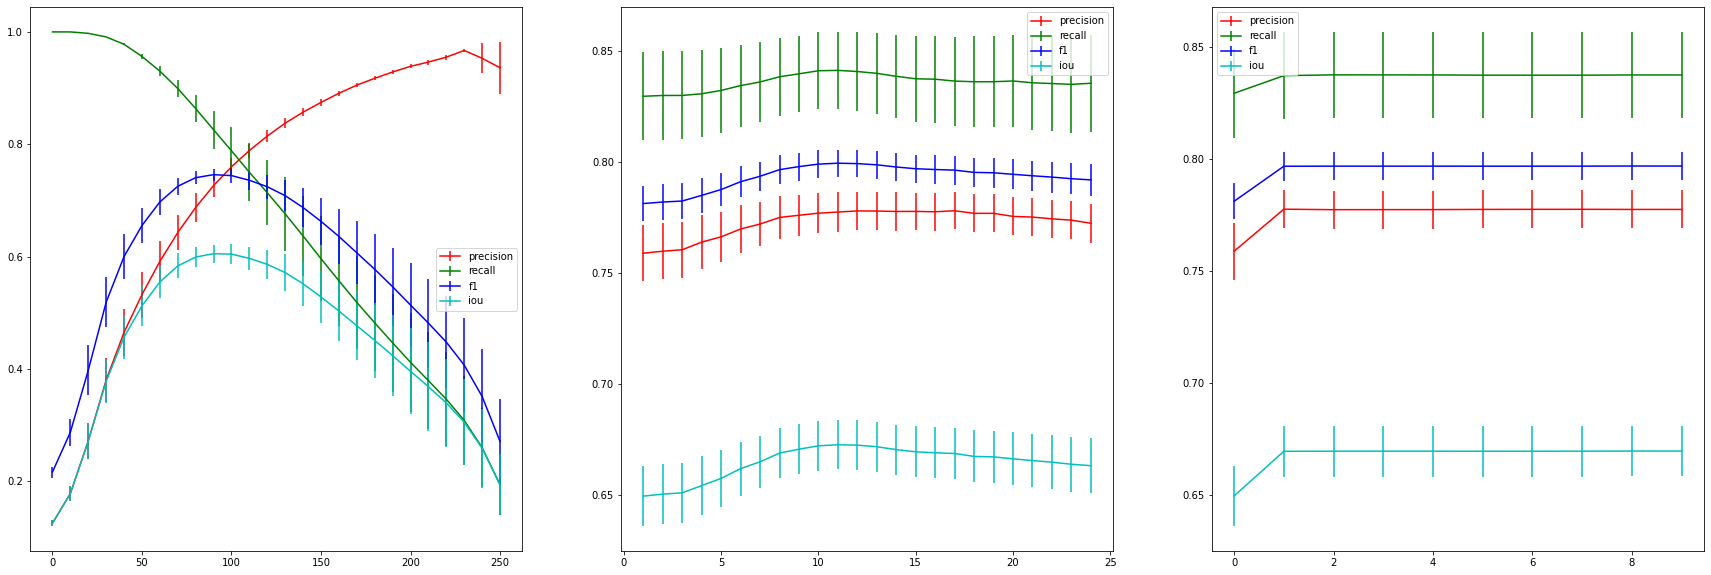

In [19]:
plot_results({}, params, loader, metric_labels)

#### Zadanie 4 (0.0 pkt | 0.5 pkt)

Przetestuj działanie tak skalibrowanego algorytmu na zbiorze walidacyjnym.  
_Jak wyniki mają się do tych ze zbioru kalibracyjnego? Dlaczego?_

In [20]:
val_loader = BacteriaLoader(root='BacteriaKaggle', train=False)

print('Train:')
vals = {}
for label in metric_labels:
    vals[label] = []
for test_image, test_mask in loader:
    output = detect_bacteria(test_image, threshold=90, kernel=11, channel='mean', openings=1)
    m = measure(output, test_mask)
    for label in metric_labels:
        vals[label].append(m[label])
print('\tmean\tvar')
for label in metric_labels:
    print(label + ':\t' + str(np.mean(vals[label])) + '\t' + str(np.var(vals[label])))

print('Val:')
vals = {}
for label in metric_labels:
    vals[label] = []
for test_image, test_mask in val_loader:
    output = detect_bacteria(test_image, threshold=90, kernel=11, channel='mean', openings=1)
    m = measure(output, test_mask)
    for label in metric_labels:
        vals[label].append(m[label])
print('\tmean\tvar')
for label in metric_labels:
    print(label + ':\t' + str(np.mean(vals[label])) + '\t' + str(np.var(vals[label])))


Train:
	mean	var
precision:	0.7180151444383461	0.022181366815855464
recall:	0.8424290854044244	0.026923225137994614
f1:	0.7506174048269013	0.009679577627260051
iou:	0.610478517483988	0.015279170995441264
Val:
	mean	var
precision:	0.7245203383064405	0.02070628068535821
recall:	0.8403128254999671	0.02157554422323663
f1:	0.755959475201469	0.007221164938680213
iou:	0.6151465117037157	0.012065718806665286
